In [1]:
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
#from kgl_deepfake.nb_01a import *
from kgl_deepfake.nb_01b import *
#from kgl_deepfake.nb_02a import *
from kgl_deepfake.nb_03 import *

In [2]:
# from fastai.utils import show_install
#show_install()

### Data

In [3]:
SOURCE = Path('../data/train_sample_videos/')

In [4]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [5]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


#### Get face detector

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [7]:
detector = MTCNN(device=device, post_process=False)

#### Remove videos in which no faces are detected.  

In [8]:
fnames = [SOURCE/o for o in annots.fname]

In [9]:
hasface = get_has_face(fnames, detector)

In [10]:
annots_hasface = annots[np.array(hasface)]

#### Create `DataBunch`

In [11]:
VideoFaceList??

In [12]:
src = (VideoFaceList
       .from_df(df=annots_hasface, path=SOURCE, cols='fname', detector=detector)
       .split_by_rand_pct())

In [13]:
bs, sz = 32, 128

In [14]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

CPU times: user 49.6 s, sys: 2.66 s, total: 52.3 s
Wall time: 6.7 s


In [23]:
#%%time
#xb, yb = next(iter(data.train_dl))

CPU times: user 14.8 s, sys: 2.09 s, total: 16.9 s
Wall time: 10 s


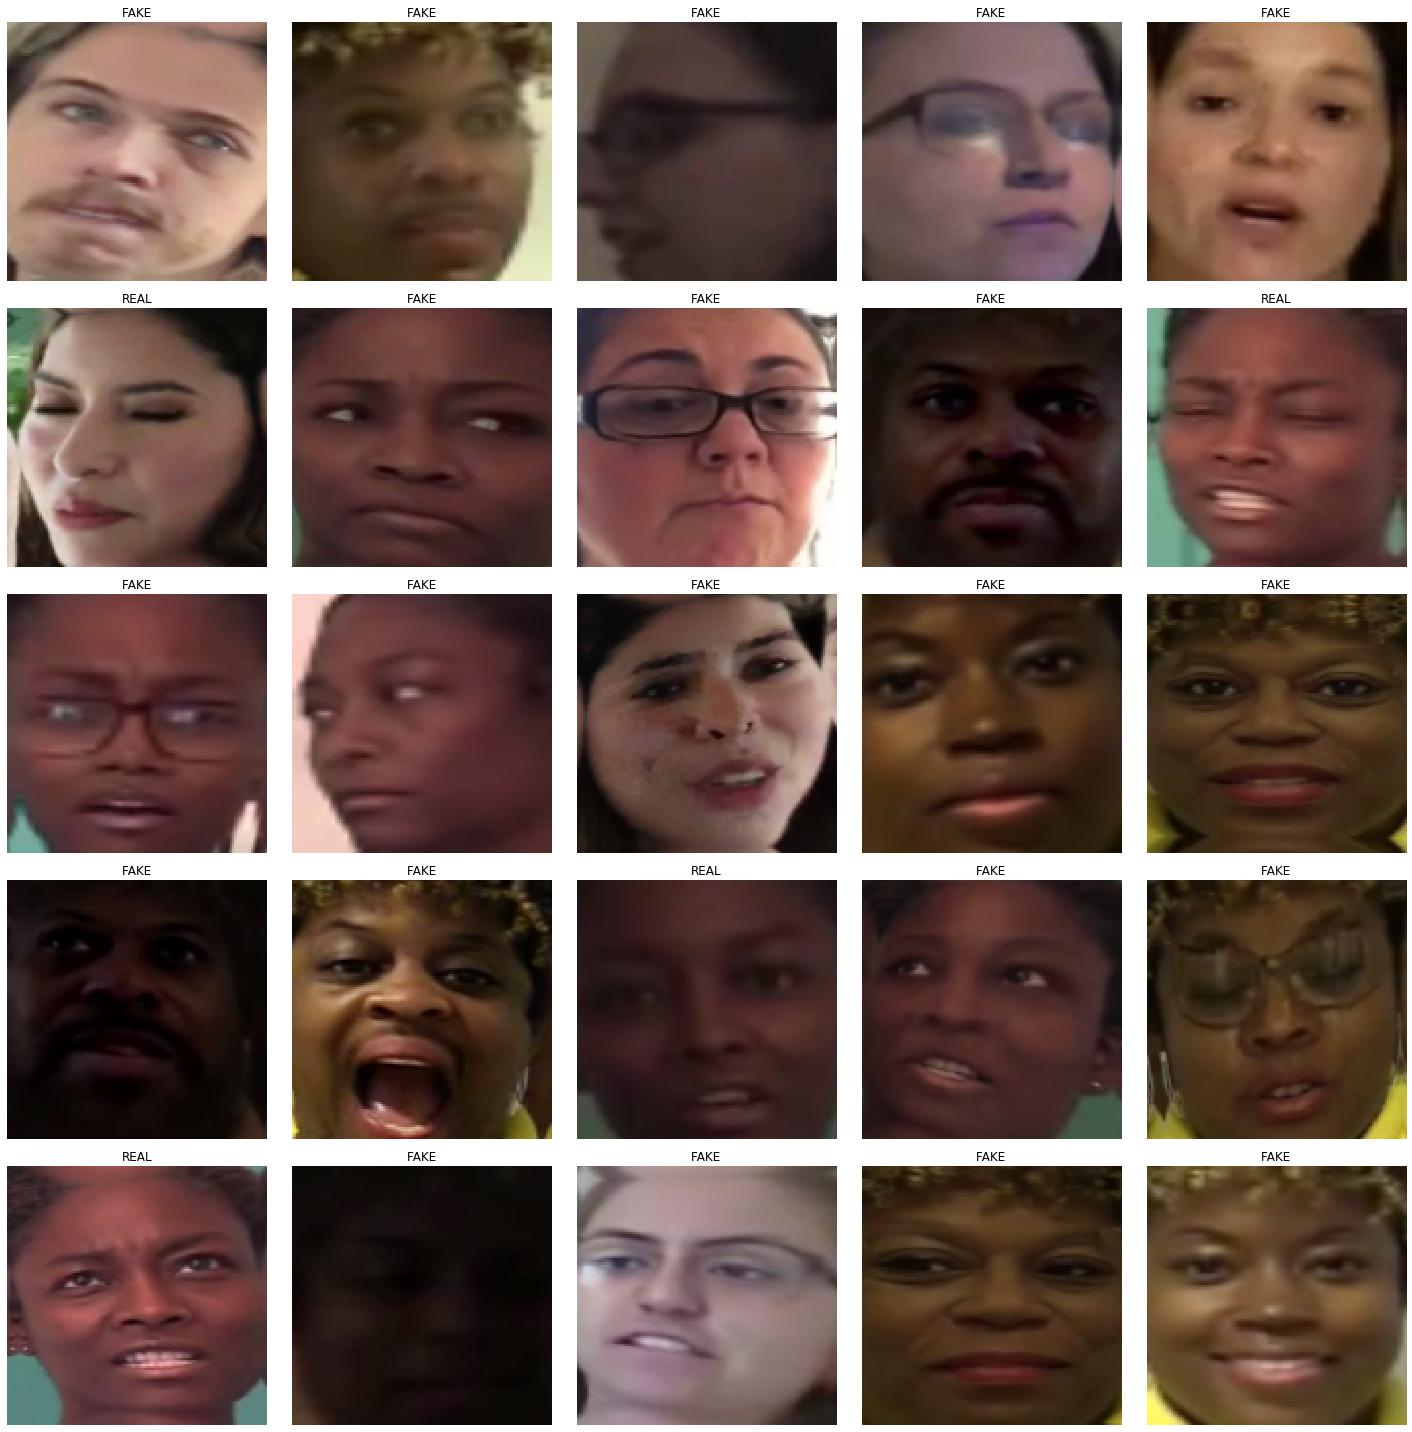

In [19]:
data.show_batch()

### Model

In [15]:
model = MesoNet()

### Learner

In [16]:
learn = Learner(data, model, metrics=accuracy)

### Train

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


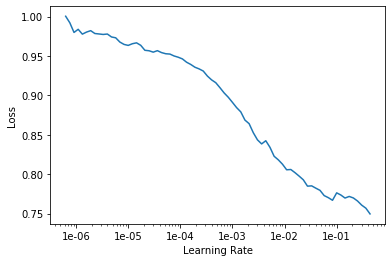

In [18]:
learn.recorder.plot()

In [ ]:
learn.fit